PyGSLIB
========

Introduction
---------------

This is a simple example on how to use raw pyslib to compute variograms




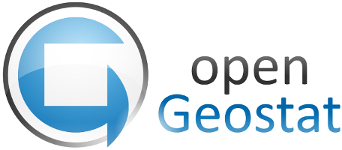

In [1]:
#general imports
import pygslib                  

Getting the data ready for work
---------
If the data is in GSLIB format you can use the function `pygslib.gslib.read_gslib_file(filename)` to import the data into a Pandas DataFrame. 


In [2]:
#get the data in gslib format into a pandas Dataframe
mydata= pygslib.gslib.read_gslib_file('../datasets/cluster.dat')  

In [4]:
# This is a 2D file, in this GSLIB version we require 3D data and drillhole name or domain code
# so, we are adding constant elevation = 0 and a dummy BHID = 1 
mydata['Zlocation']=0.
mydata['bhid']=1.

# printing to verify results
print (' \n **** 5 first rows in my datafile \n\n  ', mydata.head(n=5))

 
 **** 5 first rows in my datafile 

      Xlocation  Ylocation  Primary  Secondary  Declustering Weight  Zlocation  \
0       39.5       18.5     0.06       0.22                1.619        0.0   
1        5.5        1.5     0.06       0.27                1.619        0.0   
2       38.5        5.5     0.08       0.40                1.416        0.0   
3       20.5        1.5     0.09       0.39                1.821        0.0   
4       27.5       14.5     0.09       0.24                1.349        0.0   

   bhid  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  


## Testing variogram function gamv

In [5]:
# these are the parameters we need. Note that at difference of GSLIB this dictionary also stores 
# the actual data (ex, X, Y, etc.). 

#important! python is case sensitive 'bhid' is not equal to 'BHID'


parameters = {
            'x'    : mydata['Xlocation'].values,
            'y'    : mydata['Ylocation'].values,
            'z'    : mydata['Zlocation'].values, 
            'bhid' : mydata['bhid'].values,
            'vr'   : mydata['Primary'].values,
            'tmin' : -1.0e21,
            'tmax' :  1.0e21,
            'nlag' :  10,
            'xlag' :  1,
            'ndir' : 10,
            'ndip' :  10,
            'orgdir': 0.,
            'orgdip': 0.,
            'isill' : 1,
            'sills' : [mydata['Primary'].var()],
            'ivtail' : [1],
            'ivhead' : [1],
            'ivtype' : [1]
        }


In [6]:
#Now we are ready to calculate the veriogram
np, dis, gam, hm, tm, hv, tv = pygslib.gslib.gamv3D(parameters)

In [7]:
np

array([[[[140.],
         [ 14.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.]],

        [[ 19.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.]],

        [[  9.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.]],

        [[ 13.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.]],

        [[  7.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.]],

        [[ 12.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
         [  0.],
    

In [9]:
# create structured grid with data 

import vtk
import vtk.util.numpy_support as vtknumpy
import math
import numpy as np

XYZPts = vtk.vtkPoints()
XYZPts.SetNumberOfPoints(parameters['ndip']*parameters['nlag']*parameters['ndir']*2)

angdir = (math.pi/180.)*180./(parameters['ndir'])
angdip = (math.pi/180.)*90./(parameters['ndip'])
orgdir = parameters['orgdir'] * math.pi/180.
orgdip = parameters['orgdip'] * math.pi/180.

id=-1
for k in range(-parameters['ndip']+1,parameters['ndip']+1):
    for j in range(parameters['nlag']):
        for i in range(parameters['ndir']):
            id+=1
             
            x= parameters['xlag']*(j+1)*math.cos(angdir*i-orgdir)*math.cos(angdip*k-orgdip)
            y= parameters['xlag']*(j+1)*math.sin(angdir*i-orgdir)*math.cos(angdip*k-orgdip)
            z= parameters['xlag']*(j+1)*                            math.sin(angdip*k-orgdip)
            
            print (id, i,j,k, angdir*i*(180/math.pi), angdip*k*(180/math.pi),x,y,z)
            #print math.cos(angdip*k-orgdip)
            XYZPts.SetPoint(id,x,y,z)
                     

XYZGrid = vtk.vtkStructuredGrid()
XYZGrid.SetDimensions(parameters['ndir'],parameters['nlag'],parameters['ndip']*2-1)
XYZGrid.SetPoints(XYZPts)


ptid = np.arange(2*parameters['ndip']*parameters['nlag']*(parameters['ndir']))
cscalars = vtknumpy.numpy_to_vtk(ptid)
cscalars.SetName('PointID|') 
XYZGrid.GetPointData().AddArray(cscalars)


#Write file
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName("output.vts")
writer.SetInputData(XYZGrid)
writer.Write()

0 0 0 -9 0.0 -81.0 0.15643446504023092 0.0 -0.9876883405951378
1 1 0 -9 18.0 -81.0 0.148778017349658 0.04834090820338494 -0.9876883405951378
2 2 0 -9 36.0 -81.0 0.1265581407235004 0.0919498715009102 -0.9876883405951378
3 3 0 -9 54.0 -81.0 0.0919498715009102 0.1265581407235004 -0.9876883405951378
4 4 0 -9 72.0 -81.0 0.04834090820338496 0.148778017349658 -0.9876883405951378
5 5 0 -9 90.0 -81.0 9.578848344392366e-18 0.15643446504023092 -0.9876883405951378
6 6 0 -9 108.0 -81.0 -0.048340908203384936 0.14877801734965804 -0.9876883405951378
7 7 0 -9 126.0 -81.0 -0.09194987150091019 0.1265581407235004 -0.9876883405951378
8 8 0 -9 144.0 -81.0 -0.1265581407235004 0.09194987150091022 -0.9876883405951378
9 9 0 -9 162.0 -81.0 -0.148778017349658 0.048340908203384964 -0.9876883405951378
10 0 1 -9 0.0 -81.0 0.31286893008046185 0.0 -1.9753766811902755
11 1 1 -9 18.0 -81.0 0.297556034699316 0.09668181640676989 -1.9753766811902755
12 2 1 -9 36.0 -81.0 0.2531162814470008 0.1838997430018204 -1.975376681190

203 3 0 -7 54.0 -63.0 0.2668489204277955 0.3672860295740686 -0.8910065241883678
204 4 0 -7 72.0 -63.0 0.14029077970429513 0.43177062311338926 -0.8910065241883678
205 5 0 -7 90.0 -63.0 2.7798900617467165e-17 0.45399049973954686 -0.8910065241883678
206 6 0 -7 108.0 -63.0 -0.14029077970429507 0.4317706231133893 -0.8910065241883678
207 7 0 -7 126.0 -63.0 -0.26684892042779546 0.3672860295740686 -0.8910065241883678
208 8 0 -7 144.0 -63.0 -0.36728602957406853 0.26684892042779557 -0.8910065241883678
209 9 0 -7 162.0 -63.0 -0.43177062311338926 0.14029077970429515 -0.8910065241883678
210 0 1 -7 0.0 -63.0 0.9079809994790937 0.0 -1.7820130483767356
211 1 1 -7 18.0 -63.0 0.8635412462267785 0.2805815594085902 -1.7820130483767356
212 2 1 -7 36.0 -63.0 0.7345720591481372 0.533697840855591 -1.7820130483767356
213 3 1 -7 54.0 -63.0 0.533697840855591 0.7345720591481372 -1.7820130483767356
214 4 1 -7 72.0 -63.0 0.28058155940859025 0.8635412462267785 -1.7820130483767356
215 5 1 -7 90.0 -63.0 5.559780123493

314 4 1 -6 72.0 -54.0 0.3632712640026805 1.118033988749895 -1.618033988749895
315 5 1 -6 90.0 -54.0 7.198293278059966e-17 1.1755705045849463 -1.618033988749895
316 6 1 -6 108.0 -54.0 -0.36327126400268034 1.118033988749895 -1.618033988749895
317 7 1 -6 126.0 -54.0 -0.6909830056250524 0.9510565162951536 -1.618033988749895
318 8 1 -6 144.0 -54.0 -0.9510565162951535 0.6909830056250528 -1.618033988749895
319 9 1 -6 162.0 -54.0 -1.118033988749895 0.36327126400268056 -1.618033988749895
320 0 2 -6 0.0 -54.0 1.7633557568774194 0.0 -2.4270509831248424
321 1 2 -6 18.0 -54.0 1.6770509831248421 0.5449068960040205 -2.4270509831248424
322 2 2 -6 36.0 -54.0 1.4265847744427305 1.0364745084375788 -2.4270509831248424
323 3 2 -6 54.0 -54.0 1.0364745084375788 1.4265847744427305 -2.4270509831248424
324 4 2 -6 72.0 -54.0 0.5449068960040208 1.6770509831248421 -2.4270509831248424
325 5 2 -6 90.0 -54.0 1.079743991708995e-16 1.7633557568774194 -2.4270509831248424
326 6 2 -6 108.0 -54.0 -0.5449068960040205 1.6770

436 6 3 -5 108.0 -45.0 -0.874032048897642 2.6899940478558295 -2.8284271247461903
437 7 3 -5 126.0 -45.0 -1.6625077511098136 2.2882456112707374 -2.8284271247461903
438 8 3 -5 144.0 -45.0 -2.288245611270737 1.662507751109814 -2.8284271247461903
439 9 3 -5 162.0 -45.0 -2.6899940478558295 0.8740320488976424 -2.8284271247461903
440 0 4 -5 0.0 -45.0 3.5355339059327378 0.0 -3.5355339059327378
441 1 4 -5 18.0 -45.0 3.3624925598197866 1.0925400611220526 -3.5355339059327378
442 2 4 -5 36.0 -45.0 2.8603070140884217 2.0781346888872676 -3.5355339059327378
443 3 4 -5 54.0 -45.0 2.0781346888872676 2.8603070140884217 -3.5355339059327378
444 4 4 -5 72.0 -45.0 1.0925400611220528 3.3624925598197866 -3.5355339059327378
445 5 4 -5 90.0 -45.0 2.1648901405887336e-16 3.5355339059327378 -3.5355339059327378
446 6 4 -5 108.0 -45.0 -1.0925400611220526 3.362492559819787 -3.5355339059327378
447 7 4 -5 126.0 -45.0 -2.0781346888872667 2.8603070140884217 -3.5355339059327378
448 8 4 -5 144.0 -45.0 -2.8603070140884213 2

602 2 0 -3 36.0 -27.0 0.7208394201673423 0.5237204946142994 -0.45399049973954675
603 3 0 -3 54.0 -27.0 0.5237204946142994 0.7208394201673423 -0.45399049973954675
604 4 0 -3 72.0 -27.0 0.27533615807315837 0.8473975608908426 -0.45399049973954675
605 5 0 -3 90.0 -27.0 5.4558414393334676e-17 0.8910065241883679 -0.45399049973954675
606 6 0 -3 108.0 -27.0 -0.27533615807315825 0.8473975608908427 -0.45399049973954675
607 7 0 -3 126.0 -27.0 -0.5237204946142993 0.7208394201673423 -0.45399049973954675
608 8 0 -3 144.0 -27.0 -0.7208394201673423 0.5237204946142995 -0.45399049973954675
609 9 0 -3 162.0 -27.0 -0.8473975608908426 0.2753361580731584 -0.45399049973954675
610 0 1 -3 0.0 -27.0 1.7820130483767358 0.0 -0.9079809994790935
611 1 1 -3 18.0 -27.0 1.6947951217816852 0.5506723161463166 -0.9079809994790935
612 2 1 -3 36.0 -27.0 1.4416788403346845 1.0474409892285987 -0.9079809994790935
613 3 1 -3 54.0 -27.0 1.0474409892285987 1.4416788403346845 -0.9079809994790935
614 4 1 -3 72.0 -27.0 0.5506723161

769 9 6 -2 162.0 -18.0 -6.331559480312316 2.0572483830236563 -2.1631189606246317
770 0 7 -2 0.0 -18.0 7.608452130361228 0.0 -2.472135954999579
771 1 7 -2 18.0 -18.0 7.236067977499789 2.351141009169892 -2.472135954999579
772 2 7 -2 36.0 -18.0 6.155367074350507 4.47213595499958 -2.472135954999579
773 3 7 -2 54.0 -18.0 4.47213595499958 6.155367074350507 -2.472135954999579
774 4 7 -2 72.0 -18.0 2.3511410091698925 7.236067977499789 -2.472135954999579
775 5 7 -2 90.0 -18.0 4.658833273956369e-16 7.608452130361228 -2.472135954999579
776 6 7 -2 108.0 -18.0 -2.3511410091698917 7.23606797749979 -2.472135954999579
777 7 7 -2 126.0 -18.0 -4.472135954999579 6.155367074350507 -2.472135954999579
778 8 7 -2 144.0 -18.0 -6.155367074350506 4.4721359549995805 -2.472135954999579
779 9 7 -2 162.0 -18.0 -7.236067977499789 2.351141009169893 -2.472135954999579
780 0 8 -2 0.0 -18.0 8.559508646656381 0.0 -2.7811529493745266
781 1 8 -2 18.0 -18.0 8.140576474687261 2.645033635316129 -2.7811529493745266
782 2 8 -2 

936 6 3 0 108.0 0.0 -1.2360679774997894 3.8042260651806146 0.0
937 7 3 0 126.0 0.0 -2.351141009169892 3.23606797749979 0.0
938 8 3 0 144.0 0.0 -3.2360679774997894 2.351141009169893 0.0
939 9 3 0 162.0 0.0 -3.804226065180614 1.23606797749979 0.0
940 0 4 0 0.0 0.0 5.0 0.0 0.0
941 1 4 0 18.0 0.0 4.755282581475767 1.545084971874737 0.0
942 2 4 0 36.0 0.0 4.045084971874737 2.938926261462366 0.0
943 3 4 0 54.0 0.0 2.938926261462366 4.045084971874737 0.0
944 4 4 0 72.0 0.0 1.5450849718747373 4.755282581475767 0.0
945 5 4 0 90.0 0.0 3.061616997868383e-16 5.0 0.0
946 6 4 0 108.0 0.0 -1.5450849718747368 4.755282581475768 0.0
947 7 4 0 126.0 0.0 -2.938926261462365 4.045084971874737 0.0
948 8 4 0 144.0 0.0 -4.045084971874736 2.9389262614623664 0.0
949 9 4 0 162.0 0.0 -4.755282581475767 1.5450849718747375 0.0
950 0 5 0 0.0 0.0 6.0 0.0 0.0
951 1 5 0 18.0 0.0 5.706339097770921 1.8541019662496843 0.0
952 2 5 0 36.0 0.0 4.854101966249685 3.526711513754839 0.0
953 3 5 0 54.0 0.0 3.526711513754839 4.8541

1102 2 0 2 36.0 18.0 0.7694208842938134 0.5590169943749475 0.3090169943749474
1103 3 0 2 54.0 18.0 0.5590169943749475 0.7694208842938134 0.3090169943749474
1104 4 0 2 72.0 18.0 0.29389262614623657 0.9045084971874736 0.3090169943749474
1105 5 0 2 90.0 18.0 5.823541592445462e-17 0.9510565162951535 0.3090169943749474
1106 6 0 2 108.0 18.0 -0.29389262614623646 0.9045084971874737 0.3090169943749474
1107 7 0 2 126.0 18.0 -0.5590169943749473 0.7694208842938134 0.3090169943749474
1108 8 0 2 144.0 18.0 -0.7694208842938133 0.5590169943749476 0.3090169943749474
1109 9 0 2 162.0 18.0 -0.9045084971874736 0.2938926261462366 0.3090169943749474
1110 0 1 2 0.0 18.0 1.902113032590307 0.0 0.6180339887498948
1111 1 1 2 18.0 18.0 1.8090169943749472 0.587785252292473 0.6180339887498948
1112 2 1 2 36.0 18.0 1.5388417685876268 1.118033988749895 0.6180339887498948
1113 3 1 2 54.0 18.0 1.118033988749895 1.5388417685876268 0.6180339887498948
1114 4 1 2 72.0 18.0 0.5877852522924731 1.8090169943749472 0.6180339887

1269 9 6 3 162.0 27.0 -5.931782926235898 1.927353106512109 3.1779334981768272
1270 0 7 3 0.0 27.0 7.128052193506943 0.0 3.631923997916374
1271 1 7 3 18.0 27.0 6.779180487126741 2.2026892645852665 3.631923997916374
1272 2 7 3 36.0 27.0 5.766715361338738 4.189763956914395 3.631923997916374
1273 3 7 3 54.0 27.0 4.189763956914395 5.766715361338738 3.631923997916374
1274 4 7 3 72.0 27.0 2.202689264585267 6.779180487126741 3.631923997916374
1275 5 7 3 90.0 27.0 4.364673151466774e-16 7.128052193506943 3.631923997916374
1276 6 7 3 108.0 27.0 -2.202689264585266 6.779180487126742 3.631923997916374
1277 7 7 3 126.0 27.0 -4.189763956914394 5.766715361338738 3.631923997916374
1278 8 7 3 144.0 27.0 -5.766715361338738 4.189763956914396 3.631923997916374
1279 9 7 3 162.0 27.0 -6.779180487126741 2.2026892645852674 3.631923997916374
1280 0 8 3 0.0 27.0 8.01905871769531 0.0 4.085914497655921
1281 1 8 3 18.0 27.0 7.626578048017583 2.478025422658425 4.085914497655921
1282 2 8 3 36.0 27.0 6.487554781506081 

1435 5 3 5 90.0 45.0 1.7319121124709868e-16 2.8284271247461903 2.8284271247461903
1436 6 3 5 108.0 45.0 -0.874032048897642 2.6899940478558295 2.8284271247461903
1437 7 3 5 126.0 45.0 -1.6625077511098136 2.2882456112707374 2.8284271247461903
1438 8 3 5 144.0 45.0 -2.288245611270737 1.662507751109814 2.8284271247461903
1439 9 3 5 162.0 45.0 -2.6899940478558295 0.8740320488976424 2.8284271247461903
1440 0 4 5 0.0 45.0 3.5355339059327378 0.0 3.5355339059327378
1441 1 4 5 18.0 45.0 3.3624925598197866 1.0925400611220526 3.5355339059327378
1442 2 4 5 36.0 45.0 2.8603070140884217 2.0781346888872676 3.5355339059327378
1443 3 4 5 54.0 45.0 2.0781346888872676 2.8603070140884217 3.5355339059327378
1444 4 4 5 72.0 45.0 1.0925400611220528 3.3624925598197866 3.5355339059327378
1445 5 4 5 90.0 45.0 2.1648901405887336e-16 3.5355339059327378 3.5355339059327378
1446 6 4 5 108.0 45.0 -1.0925400611220526 3.362492559819787 3.5355339059327378
1447 7 4 5 126.0 45.0 -2.0781346888872667 2.8603070140884217 3.535

1602 2 0 7 36.0 63.0 0.3672860295740686 0.2668489204277955 0.8910065241883678
1603 3 0 7 54.0 63.0 0.2668489204277955 0.3672860295740686 0.8910065241883678
1604 4 0 7 72.0 63.0 0.14029077970429513 0.43177062311338926 0.8910065241883678
1605 5 0 7 90.0 63.0 2.7798900617467165e-17 0.45399049973954686 0.8910065241883678
1606 6 0 7 108.0 63.0 -0.14029077970429507 0.4317706231133893 0.8910065241883678
1607 7 0 7 126.0 63.0 -0.26684892042779546 0.3672860295740686 0.8910065241883678
1608 8 0 7 144.0 63.0 -0.36728602957406853 0.26684892042779557 0.8910065241883678
1609 9 0 7 162.0 63.0 -0.43177062311338926 0.14029077970429515 0.8910065241883678
1610 0 1 7 0.0 63.0 0.9079809994790937 0.0 1.7820130483767356
1611 1 1 7 18.0 63.0 0.8635412462267785 0.2805815594085902 1.7820130483767356
1612 2 1 7 36.0 63.0 0.7345720591481372 0.533697840855591 1.7820130483767356
1613 3 1 7 54.0 63.0 0.533697840855591 0.7345720591481372 1.7820130483767356
1614 4 1 7 72.0 63.0 0.28058155940859025 0.8635412462267785 1

1769 9 6 8 162.0 72.0 -2.057248383023656 0.6684405196876843 6.657395614066075
1770 0 7 8 0.0 72.0 2.4721359549995796 0.0 7.608452130361228
1771 1 7 8 18.0 72.0 2.3511410091698925 0.7639320225002103 7.608452130361228
1772 2 7 8 36.0 72.0 2.0000000000000004 1.453085056010722 7.608452130361228
1773 3 7 8 54.0 72.0 1.453085056010722 2.0000000000000004 7.608452130361228
1774 4 7 8 72.0 72.0 0.7639320225002104 2.3511410091698925 7.608452130361228
1775 5 7 8 90.0 72.0 1.5137466921736602e-16 2.4721359549995796 7.608452130361228
1776 6 7 8 108.0 72.0 -0.7639320225002102 2.351141009169893 7.608452130361228
1777 7 7 8 126.0 72.0 -1.4530850560107216 2.0000000000000004 7.608452130361228
1778 8 7 8 144.0 72.0 -2.0 1.4530850560107222 7.608452130361228
1779 9 7 8 162.0 72.0 -2.3511410091698925 0.7639320225002105 7.608452130361228
1780 0 8 8 0.0 72.0 2.781152949374527 0.0 8.559508646656381
1781 1 8 8 18.0 72.0 2.645033635316129 0.8594235253127366 8.559508646656381
1782 2 8 8 36.0 72.0 2.250000000000000

1935 5 3 10 90.0 90.0 1.4997597826618576e-32 2.4492935982947064e-16 4.0
1936 6 3 10 108.0 90.0 -7.568733460868299e-17 2.329416636978185e-16 4.0
1937 7 3 10 126.0 90.0 -1.439658655611993e-16 1.9815201452341832e-16 4.0
1938 8 3 10 144.0 90.0 -1.981520145234183e-16 1.4396586556119935e-16 4.0
1939 9 3 10 162.0 90.0 -2.3294166369781847e-16 7.568733460868302e-17 4.0
1940 0 4 10 0.0 90.0 3.061616997868383e-16 0.0 5.0
1941 1 4 10 18.0 90.0 2.9117707962227305e-16 9.460916826085374e-17 5.0
1942 2 4 10 36.0 90.0 2.4769001815427294e-16 1.7995733195149918e-16 5.0
1943 3 4 10 54.0 90.0 1.7995733195149918e-16 2.4769001815427294e-16 5.0
1944 4 4 10 72.0 90.0 9.460916826085377e-17 2.9117707962227305e-16 5.0
1945 5 4 10 90.0 90.0 1.8746997283273223e-32 3.061616997868383e-16 5.0
1946 6 4 10 108.0 90.0 -9.460916826085373e-17 2.911770796222731e-16 5.0
1947 7 4 10 126.0 90.0 -1.7995733195149913e-16 2.4769001815427294e-16 5.0
1948 8 4 10 144.0 90.0 -2.4769001815427284e-16 1.799573319514992e-16 5.0
1949 9 4 1

c:\users\adrian\appdata\local\programs\python\python36\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


1